# Logistic Regression

In [1]:
#!pip install imblearn

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from imblearn.over_sampling import RandomOverSampler, SMOTE

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from src import log_reg_utils

## UDF

## Import Dataset

In [18]:
accidents = pd.read_csv('data/accidents.csv', index_col=0)

In [19]:
accidents.head(2)

,RD_NO,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,...,at_intersection,was_non_functioning_device,is_day,is_evening,is_morning,is_night,is_fall,is_spring,is_summer,is_winter
0,JC343143,07/10/2019 05:56:00 PM,35,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,ONE-WAY,NaN,...,0,0,1,0,0,0,0,0,1,0
5,JC194776,03/21/2019 10:50:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,NOT DIVIDED,4.0,...,0,0,0,0,0,1,0,1,0,0


## Process Data for Model

In [30]:
X = accidents[['is_weekend',
               'involved_pedest_cycle',
               'at_stop_sign_or_traffic_light',
               'is_day',
               #'is_evening',
               #'is_morning',
               'is_night',
               'is_rain',
               'is_sleet_snow',
               #'is_spring',
               #'is_summer',
               'is_winter',
               'is_fall',
               'POSTED_SPEED_LIMIT',
               'was_head_on',
               'was_parked']]



y = accidents['is_fatal_or_incap']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=3)

In [31]:
scaler = MinMaxScaler()
# scaler = StandardScaler()

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
oversampler = RandomOverSampler(sampling_strategy=0.5, random_state=3)
#oversampler = SMOTE(sampling_strategy=0.5, random_state=3)

X_over, y_over = oversampler.fit_resample(X_train_scaled, y_train)

### Hyperparameter Tuning

In [39]:
#solvers = ['newton-cg', 'lbfgs', 'liblinear']
c_values =  [0.01, 0.1, 1.0, 10, 100]
params_grid = dict(C=c_values)

In [40]:
log_reg = LogisticRegression(penalty='l1', solver='saga', max_iter=1000, fit_intercept=True, random_state=3)

clf = GridSearchCV(log_reg, params_grid, cv=5, verbose=0, scoring='recall')

best_model = clf.fit(X_over, y_over)

In [41]:
print('Best C: ', best_model.best_estimator_.get_params()['C'])

Best Solver:  saga
Best C:  1.0


### Train and Predict

In [42]:
penalty = 'l1'
solver='saga'
c=1.0

log_reg = LogisticRegression(penalty=penalty, solver=solver, C=c, max_iter=1000, fit_intercept=True, random_state=3)
log_reg.fit(X_over, y_over)
y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
print('\n')
print('Recall (Scores FN): ', round(recall_score(y_test, y_pred), 4))
print('Precision (Scores FP): ', round(precision_score(y_test, y_pred), 4))
print('AUC Score: ', round(roc_auc_score(y_test, y_prob), 4))

[[54902  2648]
 [  692   373]]


Recall (Scores FN):  0.3502
Precision (Scores FP):  0.1235
AUC Score:  0.7397


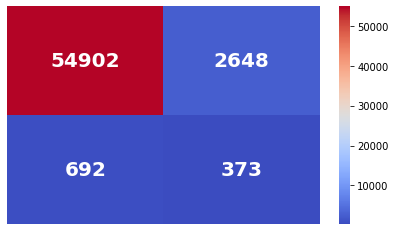

In [43]:
plt.figure(figsize=(7,4))
sns.heatmap(cf_matrix, cmap='coolwarm', annot=True, annot_kws={'size': 20, 'fontweight':'bold'}, fmt='d',
                 xticklabels=False, yticklabels=False);
#plt.savefig('img/cf_matrix.png', bbox_inches='tight')

In [44]:
coef_summary = pd.DataFrame()
coef_summary['feature_name'] = pd.Series(X.columns)
coef_summary['log_reg_coef'] = pd.Series(log_reg.coef_[0])
coef_summary.sort_values('log_reg_coef', inplace = True, ascending=False)
coef_summary

,feature_name,log_reg_coef
9,POSTED_SPEED_LIMIT,2.969303
1,involved_pedest_cycle,2.518949
10,was_head_on,1.289866
4,is_night,0.462190
2,at_stop_sign_or_traffic_light,0.249854
0,is_weekend,0.152980
5,is_rain,0.140104
8,is_fall,-0.009384
7,is_winter,-0.039203
3,is_day,-0.127501


In [45]:
print('Intercept: ', log_reg.intercept_[0])

Intercept:  -2.3847777456916046


### Test for Multicolinearity

In [46]:
type(X_over)
y_over.shape

(345027,)

In [47]:
X_over_incl_const = sm.add_constant(X_over)
model = sm.Logit(y_over, X_over_incl_const)
results = model.fit(method='cg')
results.summary()

         Current function value: 0.530451
         Iterations: 35
         Function evaluations: 100
         Gradient evaluations: 100


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      is_fatal_or_incap   No. Observations:               345027
Model:                          Logit   Df Residuals:                   345014
Method:                           MLE   Df Model:                           12
Date:                Tue, 02 Feb 2021   Pseudo R-squ.:                  0.1666
Time:                        03:45:25   Log-Likelihood:            -1.8302e+05
converged:                      False   LL-Null:                   -2.1961e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.3132      0.026    -88.710      0.000      -2.364      -2.262
x1             0.1525      0.009     16.605      0.000       0.134       0.170
x2             2.5155      0.013    193.664      0.000       2.490       2.541
x3             0.2497      0.008     29.420      0.000       0.233       0.266
x4            -0.1292      0.009    -13.988      0.000      -0.147      -0.111
x5             0.4603      0.012     39.451      0.000       0.437       0.483
x6             0.1410      0.013     10.731      0.000       0.115       0.167
x7            -0.1378      0.021     -6.631      0.000      -0.178      -0.097
x8            -0.0395      0.010     -3.868      0.000      -0.059      -0.019
x9            -0.0124      0.010     -1.283      0.199      -0.031       0.007
x10            2.8097      0.057     49.723      0.000       2.699       2.920
x11            1.2930      0.031     41.259      0.000       1.232       1.354
x12           -0.8563      0.014    -60.633      0.000      -0.884      -0.829
==============================================================================
"""

In [48]:
X_over_df = pd.DataFrame(X_over, columns=X.columns)
log_reg_utils.calc_vif(X_over_df)

,features,VIF
0,is_weekend,1.420753
1,involved_pedest_cycle,1.187800
2,at_stop_sign_or_traffic_light,1.923420
3,is_day,2.250919
4,is_night,1.568895
5,is_rain,1.134050
6,is_sleet_snow,1.110618
7,is_winter,1.694875
8,is_fall,1.678200
9,POSTED_SPEED_LIMIT,5.267211
